In [1]:
# import the usual libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import optax
import flax.linen as nn

from functools import partial
from matplotlib.colors import LogNorm

In [2]:
import cyjax

In [3]:
# random number sequence for convenience
rns = cyjax.util.PRNGSequence(42)

# Moduli dependent machine learning
First, we set up the problem by choosing the parametrized family of varieties and a monomial basis for which we try to learn $H$.

In [4]:
dwork = cyjax.Dwork(3)
degree = 3

metric = cyjax.donaldson.AlgebraicMetric(
    dwork,
    cyjax.donaldson.MonomialBasisFull(dwork.dim_projective, degree))

## Network architecture

The aim of our network is to learn a map $\psi \rightarrow H$ such that the corresponding algebraic metric is close to Ricci flat.
As a reminder, $\psi$ is the single (complex modulus) parameter of the Dwork varieties.
The $H$ matrix parametrizes the algebraic ansatz for the Kähler potential, and thus the metric.

The network here is very simple and depends only on the absolute value of $\psi$.
It is only meant for illustrative purposes.
A more realistic version can be found under the `scripts` folder in the repository.

In [5]:
# neural networks with flax are Module classes
class HNet(nn.Module):
    basis_size: int
    layer_sizes = (100, 100)
    init_fluctuation: float = 1e-3
    
    # the main logic of the neural network is defined in its __call__ function
    @nn.compact
    def __call__(self, psis):
        psis = jnp.atleast_1d(psis)
        
        # take absolute value as input feature
        # (assume here that psis have length 1;
        #  the first index after reshaping is
        #  thus the batch dimension)
        x = jnp.abs(psis).reshape(-1, 1)
        
        # apply a dense layer for each chosen hidden-layer size
        for features in self.layer_sizes:
            x = nn.Dense(features, dtype=x.dtype)(x)
            # apply a non-linear activation function
            x = nn.sigmoid(x)

        # final linear layer to H-parameters
        h_params = nn.Dense(
            self.basis_size**2, name='final_dense',
            dtype=x.dtype,
            # initialize such that H starts close to the identity
            bias_init=lambda k, s, d: cyjax.ml.hermitian_param_init(
                k, self.basis_size, self.init_fluctuation),
            kernel_init=nn.initializers.constant(0., dtype=x.dtype),
        )(x)

        # if psis initially have no batch index, remove it also
        # from the returned h-parameters
        if psis.shape == (1,):
            return jnp.squeeze(h_params, 0)
        return h_params

In [6]:
model = HNet(metric.sections.size)

psi = jnp.array(0.)
h_params, params = model.init_with_output(next(rns), psi)

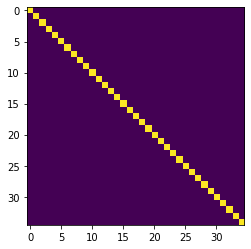

In [7]:
# initialization is close to (proportional to) identity
h = cyjax.ml.cholesky_from_param(h_params)
plt.imshow(jnp.abs(h))
plt.show()

## Loss function
For convenience, sampling is integrated into the loss function here.
First, we define a loss for a fixed moduli value.
Then, we define a batched loss which considers multiple moduli values per step.

In [8]:
def eta_loss(key, psi, h_param, sample_size):
    """Compute variance-based eta loss."""
    # create sample for MC integral
    (zs, patch), weights = dwork.sample_intersect(
        key, psi, sample_size, weights=True, affine=True)
    
    h = cyjax.ml.cholesky_from_param(h_param)

    etas = metric.eta(h, zs, psi, patch).real
    eta_mean = jnp.mean(weights * jax.lax.stop_gradient(etas)) / jnp.mean(weights)

    loss = (etas / eta_mean - 1) ** 2
    loss *= weights
    loss = jnp.mean(loss)
    
    # if g is not pos. def. eta may be negative -> penalty
    loss += jnp.mean(jnp.log(jnp.where(etas < 0, etas, 0)**2 + 1))

    return loss

In [9]:
# sample multiple values for psi & call model
def loss_function(params, key, sample_size=100, psi_rad=10, batches=4):
    key, k1 = jax.random.split(key)
    psis = cyjax.random.uniform_angle(k1, (batches, 1), 0, psi_rad)
    h_params = model.apply(params, psis)
    loss = jax.vmap(eta_loss, (0, 0, 0, None))(
        jax.random.split(key, batches),
        psis,
        h_params,
        sample_size)
    return jnp.mean(loss)

In [10]:
loss_function(params, next(rns))

Array(0.6032228, dtype=float32)

## Evaluating the accuracy
The output of the loss function is effectively an average measure (randomly chosen) over the parameter range.
We can gain slightly more insight by evaluating the accuracy over a fixed range of parameters (instead of randomly chosen in each step).
To make evaluation easy, we then show the loss in relation to $|\psi|$ together with the max/min obtained for different complex angles.

In this section, we will setup up this evaluation.
First, we pick the values of psi. Then, we define functions which evaluate the accuracies of the current approximation for these values.

We will use this in the last part, where we actually train the network.

In [11]:
# choose a range for |psi|
psi_rad = 100

In [12]:
# 10 radii & 10 complex angles
psi_radii = jnp.linspace(1, psi_rad, 5)
psi_eval = jnp.exp(1j * jnp.arange(0, 2*jnp.pi, jnp.pi/5)) * psi_radii[:, None]
psi_eval = psi_eval.reshape(-1, 1)

In [13]:
# helper function with the main logic
@jax.jit
def _accuracies(key, h_par, psi):
    h = cyjax.ml.cholesky_from_param(h_par)
    psi = jnp.atleast_1d(psi)
    return metric.sigma_accuracy(key, psi, h, 500)


# now we want to call the above for the chosen batch of psi-values
@jax.jit
def eval_accuracy(key, params):
    sig = jax.vmap(_accuracies, (None, 0, 0))(
        key, model.apply(params, psi_eval), psi_eval)
    sig = sig.reshape(5, 10)
    # average/min/max over the angles for each |psi|
    mean = jnp.mean(sig, 1)
    smin = jnp.max(sig, 1)
    smax = jnp.min(sig, 1)
    return mean, smin, smax

In [14]:
# By evaluating the above function, we get the mean, min, and max values of the sigma accuracies
# for each value of |psi|. We can nicely visualize this in a simple plot.
smean, smin, smax = eval_accuracy(next(rns), params)

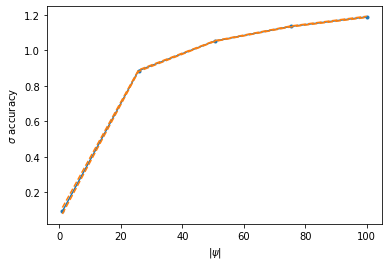

In [15]:
# Note that the initialization, i.e. H=1 gives a relatively good approximation near 0,
# i.e. for the most-symmetric Fermat quintic.
plt.plot(psi_radii, smean, '.-', color='C0')
plt.plot(psi_radii, smin, '--', color='C1')
plt.plot(psi_radii, smax, '--', color='C1')
plt.xlabel(r'$|\psi|$')
plt.ylabel('$\sigma$ accuracy')
plt.show()

## Training

Note: The example here is for illustrative purposes and is meant to run fast rather than give optimal results.

In [16]:
from tqdm import tqdm  # show progress bar

In [17]:
# initialize optimizer (adam) with an initial learning rate of 10^(-3)
opt = optax.adam(1e-3)
opt_state = opt.init(params)

In [18]:
# define the update step, which returns the new parameters (and state) given the old one

@jax.jit  # jit-compile for speed
def update_step(key, params, opt_state):
    # comptue gradients
    grads = jax.grad(loss_function)(params, key)
    # compute updates (change to parameters) given gradient and optimizer algorithm
    updates, opt_state = opt.update(grads, opt_state)
    # apply updates to the parameters (i.e. gradient descent)
    params = optax.apply_updates(params, updates)
    # return new parameters
    return params, opt_state

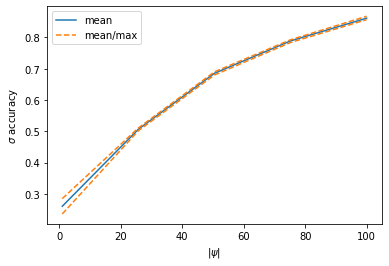

100%|█████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.91it/s]


In [19]:
n_steps = 100  # total number of steps (very small, increase for better results)
plot_every = 50  # update the plot after this many steps

# set up plotting of accuracies to monitor training
fig = plt.figure()
ax = plt.gca()
acc_line, = plt.plot(psi_radii, smean, label='mean')
min_line, = plt.plot(psi_radii, smin, '--', color='C1', label='mean/max')
max_line, = plt.plot(psi_radii, smax, '--', color='C1')
plt.legend()
plt.xlabel(r'$|\psi|$')
plt.ylabel('$\sigma$ accuracy')
display_id = display(fig, display_id=True)
display_id.update(fig)

# training loop
for i in tqdm(range(n_steps)):
    
    # apply training step
    params, opt_state = update_step(next(rns), params, opt_state)
    
    # after chosen number of steps, evaluate and update the plot
    if (i + 1) % plot_every == 0:
        smean, smin, smax = eval_accuracy(next(rns), params)
        acc_line.set_ydata(smean)
        min_line.set_ydata(smin)
        max_line.set_ydata(smax)
        ax.relim()
        ax.autoscale_view()
        display_id.update(fig)

plt.close()